In [1]:
from functools import partial
from typing import Any, Optional

import torch
import torch.nn as nn


__all__ = ["AlexNet"]


In [9]:

class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000, dropout: float = 0.5) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

if __name__ == "__main__":
    alexnet = AlexNet()
    ex = torch.randn(64, 3, 224, 224)
    output = alexnet(ex)
    print(output.shape)  # Should be (64, 1000)

torch.Size([64, 1000])


### Resizing Images

In [7]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

# Device configuration
device = torch.device('mps' if torch.cuda.is_available() else 'cpu')

In [11]:
def get_train_valid_loader(data_dir,
                               batch_size,
                               augment,
                               random_seed,
                               valid_size=0.1,
                               shuffle=True):
        normalize = transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.2023, 0.1994, 0.2010],
        )

        # define transforms
        valid_transform = transforms.Compose([
                transforms.Resize((224,224)),
                transforms.ToTensor(),
                normalize,
        ])
        if augment:
            train_transform = transforms.Compose([
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                normalize,
            ])
        else:
            train_transform = transforms.Compose([
                transforms.Resize((224,224)),
                transforms.ToTensor(),
                normalize,
            ])

        # load the dataset
        train_dataset = datasets.CIFAR10(
            root=data_dir, train=True,
            download=True, transform=train_transform,
        )

        valid_dataset = datasets.CIFAR10(
            root=data_dir, train=True,
            download=True, transform=valid_transform,
        )

        num_train = len(train_dataset)
        indices = list(range(num_train))
        split = int(np.floor(valid_size * num_train))

        if shuffle:
            np.random.seed(random_seed)
            np.random.shuffle(indices)

        train_idx, valid_idx = indices[split:], indices[:split]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=batch_size, sampler=train_sampler)

        valid_loader = torch.utils.data.DataLoader(
            valid_dataset, batch_size=batch_size, sampler=valid_sampler)

        return (train_loader, valid_loader)


def get_test_loader(data_dir,
                    batch_size,
                    shuffle=True):
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )

    # define transform
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize,
    ])

    dataset = datasets.CIFAR10(
        root=data_dir, train=False,
        download=True, transform=transform,
    )

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle
    )

    return data_loader

# CIFAR10 dataset 
train_loader, valid_loader = get_train_valid_loader(data_dir = './data',batch_size = 64,augment = False,random_seed = 1)

test_loader = get_test_loader(data_dir = './data', batch_size = 64)

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision

def visualize_model_outputs(model, dataloader, num_images=5, classes=None, device=None):
    """
    Visualize input images and model predictions.
    
    Args:
        model: Trained PyTorch model
        dataloader: DataLoader containing images
        num_images: Number of images to visualize
        classes: List of class names (for CIFAR10: ['airplane', 'automobile', ...])
        device: Device to run the model on ('cpu', 'mps', or 'cuda')
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    if classes is None:
        classes = ('airplane', 'automobile', 'bird', 'cat',
                   'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    
    # Set model to evaluation mode
    model.eval()
    model = model.to(device)
    
    # Get a batch of images
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    images = images[:num_images]
    labels = labels[:num_images]
    
    # Make predictions
    with torch.no_grad():
        images_device = images.to(device)
        outputs = model(images_device)
        _, predicted = torch.max(outputs, 1)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    
    # Create figure with subplots
    fig, axes = plt.subplots(nrows=num_images, ncols=2, figsize=(12, 3*num_images))
    
    # Function to denormalize images for visualization
    def denormalize(tensor):
        # For CIFAR10 from test_loader
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        return tensor * std + mean
    
    # Plot each image and its corresponding prediction
    for i in range(num_images):
        # Plot original image
        img = denormalize(images[i]).cpu()
        img = np.transpose(img, (1, 2, 0))  # Change from CxHxW to HxWxC
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"True: {classes[labels[i]]}")
        axes[i, 0].axis('off')
        
        # Plot bar chart of probabilities
        probs = probabilities[i].cpu().numpy()
        y_pos = np.arange(len(classes))
        axes[i, 1].barh(y_pos, probs, align='center')
        axes[i, 1].set_yticks(y_pos)
        axes[i, 1].set_yticklabels(classes)
        axes[i, 1].set_title(f"Predicted: {classes[predicted[i]]}")
        axes[i, 1].set_xlim(0, 1)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("Prediction Summary:")
    for i in range(num_images):
        print(f"Image {i+1}: True: {classes[labels[i]]}, Predicted: {classes[predicted[i]]}")

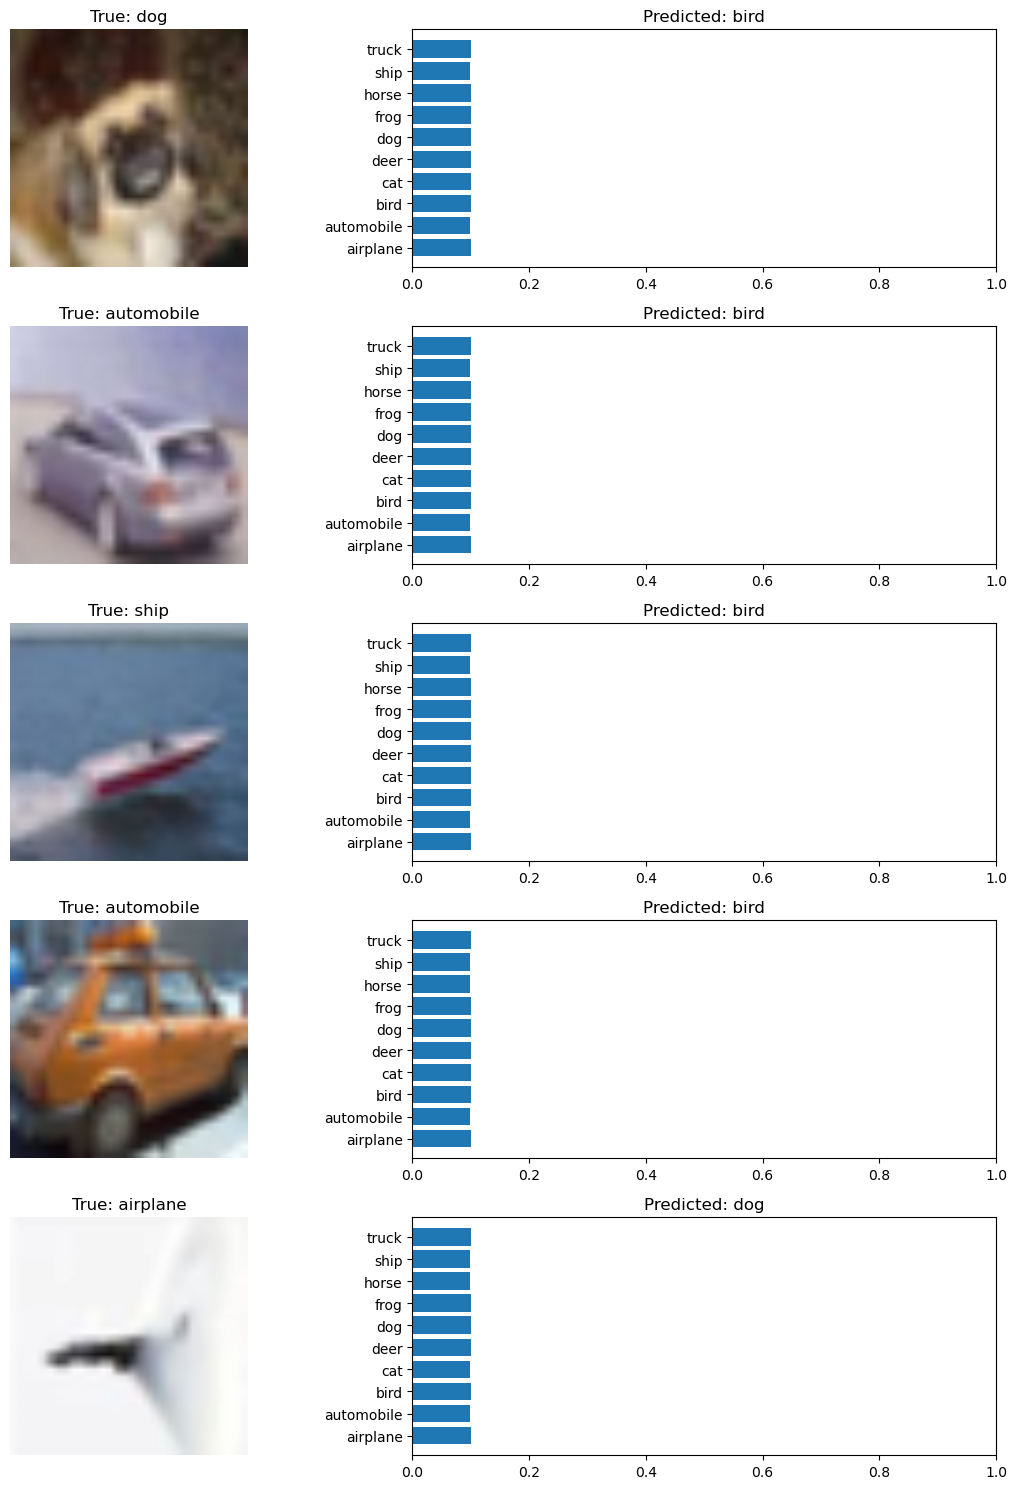

Prediction Summary:
Image 1: True: dog, Predicted: bird
Image 2: True: automobile, Predicted: bird
Image 3: True: ship, Predicted: bird
Image 4: True: automobile, Predicted: bird
Image 5: True: airplane, Predicted: dog


In [13]:
# Load the AlexNet model
model = AlexNet(num_classes=10)  # CIFAR10 has 10 classes

# You can use either test_loader or valid_loader
visualize_model_outputs(
    model=model, 
    dataloader=test_loader, 
    num_images=5,
    device='mps'  # Use 'cpu', 'cuda', or 'mps' (for Mac)
)

### ConvNN Alex Net

In [12]:
import sys

sys.path.append("../Layers")
from Conv2d_NN import Conv2d_NN

__all__ = ["AlexNet"]


class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000, dropout: float = 0.5) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            Conv2d_NN(3, 64, K=11, stride=11, samples=15, shuffle_pattern="NA", shuffle_scale=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (64, 111, 111) -> (64, 55, 55)
            Conv2d_NN(64, 192, K=5, stride=5, samples=15, shuffle_pattern="NA", shuffle_scale=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (192, 55, 55) -> (192, 27, 27)
            Conv2d_NN(192, 384, K=3, stride=3, samples=15, shuffle_pattern="NA", shuffle_scale=1),
            nn.ReLU(inplace=True),
            Conv2d_NN(384, 256, K=3, stride=3, samples=15, shuffle_pattern="NA", shuffle_scale=1),
            nn.ReLU(inplace=True),
            Conv2d_NN(256, 256, K=3, stride=3, shuffle_pattern="NA", shuffle_scale=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (256, 27, 27) -> (256, 13, 13)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


if __name__ == "__main__":
    alexnet = AlexNet()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    alexnet = alexnet.to(device)

    # Create sample input
    x = torch.randn(1, 3, 224, 224).to(device)

    # Track feature extractor layers
    print("Feature Extractor Layers:")
    print(f"Input shape: {x.shape}")

    # First Conv + ReLU
    x = alexnet.features[0](x)
    print(f"After Conv1 (64 filters, k=11, s=1): {x.shape}")
    x = alexnet.features[1](x)  # ReLU doesn't change shape

    # First MaxPool
    x = alexnet.features[2](x)
    print(f"After MaxPool1 (k=3, s=2): {x.shape}")

    # Second Conv + ReLU
    x = alexnet.features[3](x)
    print(f"After Conv2 (192 filters, k=5, s=1): {x.shape}")
    x = alexnet.features[4](x)  # ReLU

    # Second MaxPool
    x = alexnet.features[5](x)
    print(f"After MaxPool2 (k=3, s=2): {x.shape}")

    # Third Conv + ReLU
    x = alexnet.features[6](x)
    print(f"After Conv3 (384 filters, k=3, s=1): {x.shape}")
    x = alexnet.features[7](x)  # ReLU

    # Fourth Conv + ReLU
    x = alexnet.features[8](x)
    print(f"After Conv4 (256 filters, k=3, s=1): {x.shape}")
    x = alexnet.features[9](x)  # ReLU

    # Fifth Conv + ReLU
    x = alexnet.features[10](x)
    print(f"After Conv5 (256 filters, k=3, s=1): {x.shape}")
    x = alexnet.features[11](x)  # ReLU

    # Third MaxPool
    x = alexnet.features[12](x)
    print(f"After MaxPool3 (k=3, s=2): {x.shape}")

    # Adaptive average pooling
    x = alexnet.avgpool(x)
    print(f"After AdaptiveAvgPool (6x6): {x.shape}")

    # Flatten for fully connected layers
    x = torch.flatten(x, 1)
    print(f"After Flatten: {x.shape}")

    # Classifier layers
    print("\nClassifier Layers:")
    x = alexnet.classifier[0](x)  # Dropout doesn't change shape
    print(f"After Dropout: {x.shape}")

    x = alexnet.classifier[1](x)  # First FC
    print(f"After FC1 (4096 neurons): {x.shape}")

    x = alexnet.classifier[2](x)  # ReLU
    x = alexnet.classifier[3](x)  # Dropout

    x = alexnet.classifier[4](x)  # Second FC
    print(f"After FC2 (4096 neurons): {x.shape}")

    x = alexnet.classifier[5](x)  # ReLU

    x = alexnet.classifier[6](x)  # Output FC
    print(f"After FC3 (1000 neurons): {x.shape}")

Feature Extractor Layers:
Input shape: torch.Size([1, 3, 224, 224])
After Conv1 (64 filters, k=11, s=1): torch.Size([1, 64, 224, 224])
After MaxPool1 (k=3, s=2): torch.Size([1, 64, 111, 111])
After Conv2 (192 filters, k=5, s=1): torch.Size([1, 192, 111, 111])
After MaxPool2 (k=3, s=2): torch.Size([1, 192, 55, 55])
After Conv3 (384 filters, k=3, s=1): torch.Size([1, 384, 55, 55])
After Conv4 (256 filters, k=3, s=1): torch.Size([1, 256, 55, 55])
After Conv5 (256 filters, k=3, s=1): torch.Size([1, 256, 55, 55])
After MaxPool3 (k=3, s=2): torch.Size([1, 256, 27, 27])
After AdaptiveAvgPool (6x6): torch.Size([1, 256, 6, 6])
After Flatten: torch.Size([1, 9216])

Classifier Layers:
After Dropout: torch.Size([1, 9216])
After FC1 (4096 neurons): torch.Size([1, 4096])
After FC2 (4096 neurons): torch.Size([1, 4096])
After FC3 (1000 neurons): torch.Size([1, 1000])
